# Multi-rotor Aircraft

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S72_drone_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
from dataclasses import dataclass

import gtsam
from gtbook.drone import axes

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

```{index} action; quadrotor flight
```
> Using four (or more) rotors to fly in 3D.

<img src="Figures7/S72-Autonomous_camera_drone-06.jpg" alt="Splash image with steampunk drone in various poses" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

The dynamics and kinematics of quadrotors and in general *multi*-rotor aircraft are those of simple rigid 3D bodies. Many different coordinate frame conventions are used in the literature. We introduce one good choice below, and convert equations from the literature to this convention where needed.

```{index} navigation frame
```
```{index} pair: East-North-Up; ENU
```
```{index} pair: Universal Transverse Mercator; UTM
```
The equations for control and navigation we develop below are most useful when expressed in a local **navigation frame** $N$. For MAV applications this frame is almost always assumed to be non-rotating and aligned with gravity, but can otherwise be defined arbitrarily.
For example, the **East-North-Up (ENU)** convention defines the $x, y$ and $z$ axes along
the east, north, and upward directions, respectively.
The origin of the navigation frame is often chosen as the take-off point.
Another choice is the *UTM (Universal Transverse Mercator)* coordinate system, which defines 60 locally flat coordinate frames on earth.

```{index} body frame
```
```{index} pair: Forward-Left-Up; FLU
```
```{index} pair: Forward-Right-Down; FRD
```
We also define a **body frame** $B$ as having its origin at the center of mass of the vehicle. We fix the x-axis as pointing to the front of the vehicle (not always the direction of travel), the y-axis as pointing to the left, and the z-axis pointing up, the so-called **FLU convention**. In aerospace applications the so-called FRD convention with the z-axis *down* is also popular, but it really is just matter of choice, and we find FLU to be more intuitive.

We then define:

- the vehicle's *position* $r^{n}\doteq[x,y,z]^{T}$,

- its linear velocity $v^n=\dot{r^{n}}\doteq[u,v,w]^{T}$,

- the attitude $R^n_b\doteq[\hat{x}^n_b,\hat{y}^n_b,\hat{z}^n_b]\in SO(3)$, a $3\times 3$ rotation matrix with the columns of the body frame $B$ expressed in the navigation frame $N$,

- the body angular velocity $\omega^b\doteq[p,q,r]^{T}$.

Above the superscript $n$ and $b$ denote quantities expressed in the *navigation* and *body* frame, respectively. Together, these quantities allow us to talk about the *kinematics* of the drone: where it is and how it moves over time.

## Drone Dynamics

Kinematics alone is not enough, however: because an MAV has *mass*, we need to talk about how forces will bring about change in the velocity. One of us (Dellaert) has worked at the drone startup [Skydio](https://www.skydio.com/) and hence we will use one of its products as a prototypical example.

<figure id="fig:Skydio">
<img src="https://github.com/gtbook/robotics/blob/main/Figures7/Skydio2axes.png?raw=1" style="width:18cm" alt="">
<figcaption>Skydio 2 drone with FLU coordinate frame, and rotors labeled with coordinates. </figcaption>
</figure>

In particular, let us take the [Skydio 2](https://www.skydio.com/skydio-2-plus) as a relevant example. Its mass, with battery, is about $800g$, but let's just say $1kg$ to make the calculations easier. Its dimensions are $229mm \times 274mm$, but let us assume the motors are at $(+/- 0.10m, +/- 0.10m)$, which is not too far off. Figure [1](#fig:Skydio) illustrates the setup.

### Hover
We denote by $f_i \in \mathbb{R}$ the amount of thrust provided by the $i^{th}$ rotor.
This thrust is applied in the direction of the $z$-axis of the body frame.
To hover, assuming we approximate the local gravity constant as $g=10m/s^2$, the four rotors *together* must provide a thrust of 10N upwards to compensate for gravity, i.e., 2.5N per motor. 
Of course, we need to be able to accelerate upwards, so let's assume each motor can provide up to double that, i.e., 0 to 5N. 
If the drone is level (i.e., the body $z$-axis is aligned with the direction of gravity), here are some sample accelerations we can deliver:

- $f_i=0N$ for $i\in{1..4}$: downwards acceleration at $-10\frac{m}{s^2}$.
- $f_i=2.5N$ for $i\in{1..4}$: stable hover.
- $f_i=5N$ for $i\in{1..4}$: upwards acceleration at $10\frac{m}{s^2}$.

In general, the total force $F^b \in \mathbb{R}^3$ delivered by the rotors is aligned with the body z-axis and is equal to

\begin{equation}
F^b
=
\begin{bmatrix}0 \\ 0 \\ F^b_z\end{bmatrix}
= \sum_{i=1}^4 \begin{bmatrix}0 \\ 0 \\ 1\end{bmatrix} f_i.
\end{equation}
As long as the drone is level, and hence the body $z$-axis is aligned with gravity, we can only accelerate up or down. The net acceleration in that case is obtained simply by subtracting the acceleration due to gravity. But, of course, only being to move up or down is not very useful, and is unlikely to happen anyway because of noise, wind, and other effects. Hence, below we look at how 3D orientation plays a role.

### Forward Flight

The thrust delivered by the rotors is always aligned with the body frame's $z$-axis, and hence by rotating the quadrotor appropriately we can achieve any thrust direction in the navigation frame that we desire.
For example, when the quadrotor *tilts* forward, some of the thrust delivered by the rotors 
will be directed toward generating horizontal acceleration. 
To get a handle on this, we need to calculate the thrust in the *navigation* frame $N$. This is accomplished by multiplying the 3D force $F^b$ in the body frame with the rotation matrix $R^n_b$:
\begin{equation}
F^n = R^n_b \begin{bmatrix}0 \\ 0 \\ F^b_z\end{bmatrix} = \hat{z}^n_b F^b_z.
\end{equation}
Above $\hat{z}^n_b$ is the third column of $R^n_b$, i.e., this is simply the $z$-axis of the body frame expressed in the navigation frame.

As an example, let us assume that the Forward/$x$-axis of the FLU body frame is currently oriented along the 
North/$y$-axis of the ENU navigation frame, i.e., we are flying north. Then, if we tilt the body's Up/$z$-axis forward by an angle of $\theta$ with respect to vertical, the body $z$-axis will have a $\sin \theta$ contribution towards the north (ENU $y$-axis), and a $\cos \theta$ up (ENU $z$-axis):
\begin{equation}
\hat{z}^n_b = \begin{bmatrix}0 \\ \sin \theta \\ \cos \theta\end{bmatrix}.
\end{equation}
The thrust *vector* $F^n$ in the navigation frame is then obtained by multiplying with the total force $F^b_z$:
\begin{equation}
F^n = \begin{bmatrix}0 \\ \sin \theta \\ \cos \theta\end{bmatrix} F^b_z.
\end{equation}
The fact that $\cos \theta<1$ is potentially problematic: if we want to maintain level flight (not fall out of the sky!) we need to compensate for gravity by maintaining the constraint
\begin{equation}
F^b_z \cos \theta  = 10.
\end{equation}
That in turn means that the forward thrust (along the navigation y-axis) will be
\begin{equation}
F^n_y = F^b_z  \sin \theta = \frac{10}{\cos \theta} \sin \theta  = 10 \tan \theta  
\end{equation}
This point bears repeating: if we tilt the drone to fly in a particular direction, the upward component of the thrust vector decreases, so we will have to *increase* total thrust, or we will lose altitude.

### Maximum Tilt and Thrust

We can expand on this example to calculate what our maximum tilt angle would be, given bounded thrust. We are constrained by the maximum thrust $F^b_z$ we can deliver, which we assumed to be 20N above. Imposing this constraint in turn yields a constraint on $\cos \theta$:
\begin{equation}
F^b_z = \frac{10N}{\cos \theta} \leq 20N \rightarrow \cos \theta \geq 0.5
\end{equation}
From this we can deduce that the maximum tilt angle $\theta$ is 60 degrees:
\begin{equation}
-60^\circ \leq \theta \leq 60^\circ
\end{equation}
At that maximum tilt angle, we have
\begin{equation}
F^n_y = 10 \tan \theta_{\max} \approx 17
\end{equation}
So, we are limited to $17N$ of forward thrust, and this when tilting very aggressively at 60 degrees. If we tilt more, we can improve thrust even more (up to 20N) but the drone will quickly lose altitude. 

### Drag and Maximum Velocity

```{index} drag, drag coefficient
```
When drones fly through the air, they encounter air resistance, also known as **drag**, which
can be understood as a force that acts opposite to the motion of the drone.
Because of drag, constant forward thrust does *not* mean that the drone will continue accelerating.
From the spec-sheet of the Skydio 2 drone we can see that the top speed in autonomous mode is 36Mph,
which is about $16m/s$, while the theoretical top speed is probably more like $20m/s$. 
For air vehicles, the **drag coefficient**, which we denote by $k_d$,
relates the vehicle speed to this resistive force.
From physics we know that drag increases *quadratically* with velocity. 
Indeed, the drag force $k_d v_{top}^2$ at the top speed will exactly balance the maximum forward thrust of 17N:
\begin{equation}
k_d v_{top}^2 = 17
\end{equation}
If we assume the top speed of $20m/s$ is correct, we can estimate the drag coefficient $k_d$:
\begin{equation}
k_d 20^2= 17 \rightarrow k_d = 0.0425
\end{equation}
Given the drag coefficient $k_d$, we can calculate a simple mapping from tilt angle $\theta$ to the terminal forward velocity. For a given tilt angle $\theta$ we first calculate the forward thrust $F^n_y$ in the navigation frame:
\begin{equation}
F^n_y = \tan \theta \cdot 10N
\end{equation}
after which the velocity can be obtained by equating that to the drag force $k_d v^2$:
\begin{equation}
\tan \theta \cdot 10N = k_d v^2 \rightarrow v = \sqrt{\frac{\tan \theta \cdot 10}{k_d}}
\end{equation}
Plugging in the estimated value of $k_d$ we obtain
\begin{equation}
v \approx 15 \sqrt{\tan \theta}
\end{equation}
With a smidgen of code we can build a lookup table `vmap` and plot it in Figure [2](#fig:v_vs_theta).

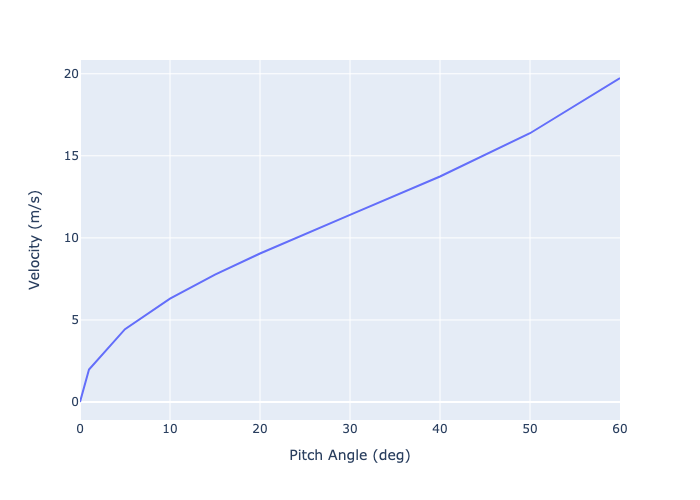

In [3]:
#| caption: Velocity vs. Pitch Angle.
#| label: fig:v_vs_theta
vmap = {}
for theta_deg in [0,1,5,10,15,20,30,40,50, 60]:
  theta_rad = math.radians(theta_deg)
  vmap[theta_deg] = 15. * math.sqrt(math.tan(theta_rad))
px.line(x=list(vmap.keys()), y= list(vmap.values()),
        labels={"x":"Pitch Angle (deg)", "y":"Velocity (m/s)"})

## Drone Kinematics

```{index} kinematics, statics, dynamics
```
The subject of **kinematics** deals exclusively with positions and velocities, not the forces and accelerations involved to obtain those velocities. Kinematics should be contrasted with **statics** or steady-state force reasoning as we did above, and **dynamics** which describes the changing forces and accelerations over time.

### Positional Kinematics

```{index} linear velocity
```
For position, the vehicle's kinematics are straightforward. The time derivative $\dot{r}^{n}$ of position $r^n$ in the navigation frame is equal to the **linear velocity** $v^n$, also in the navigation frame:
\begin{equation}
\dot{r}^{n}	= v^n.
\end{equation}

### Angular Velocity

```{index} angular velocity
```
Just as we have a linear velocity $v^n$, a three-vector, we also have a 3-dimensional **angular velocity** $\omega$,
which is typically given *in the body frame* as $\omega^b$.
In this case, the components of $\omega^b$ correspond to angular velocities around the respective body axes. 
This angular velocity vector has a very intuitive interpretation as an angle-axis interpretation: the vector can be viewed as a rotation axis in 3D, centered at the body coordinate frame, and its norm $\|\omega^b\|$ is the instantaneous angular speed around that axis. 

For example, the drone steadily pitching downward by 10 degrees/second corresponds to a positive rotation around the body $y$-axis and the corresponding angular velocity is given by
\begin{equation}
\omega^b = \begin{bmatrix}0 \\ 1 \\ 0\end{bmatrix} 10 .
\end{equation}
We use the *right hand rule*,
which defines the a positive direction of angular velocity around a given axis is defined as counter-clockwise. 
Remember that in our FLU convention the $y$-axis points leftward from the center of the drone, and hence looking from the left a counter-clockwise movement corresponds to pitching *down*.

```{index} roll, pitch, yaw
```
In an FLU body frame, each of the axes is associated with a particular rotational motion:

- **roll** is around the Forward/$x$-axis. Positive roll is to the right.
- **pitch** is around the Left/$y$-axis. Positive pitch is downward.
- **yaw** is around the Up/$z$-axis. Positive yaw is towards the left.

Note that the statements associated with positive roll, pitch or yaw above are valid only when starting from upright hover. For example, when flying upside down, obviously yaw and pitch would behave oppositely.

#### Exercise

When flying upside down but in the same direction, positive roll is still to the right. Think about it.

### Rotational Kinematics

We can use rotation matrices to generalize the example above to arbitrary angular velocities. 
In Section 7.1 we have seen that $\omega^b$ denotes the angular velocity of the body frame
expressed in the coordinates relative to the body frame.
Therefore, using the results from Section 7.1, we have
\begin{equation}
\dot{R}^n_b	= R^n_b \hat{\omega}^b
\end{equation}
The quantity $\hat{\omega}^b$ is a $3\times 3$ skew-symmetric matrix, related to the angular velocity $\omega^b$ as follows:
\begin{equation}
\hat{\omega}^b\doteq\begin{bmatrix}
0 & -\omega^b_{z} & \omega^b_{y}\\
\omega^b_{z} &  0& -\omega^b_{x}\\
-\omega^b_{y} & \omega^b_{x} &0
\end{bmatrix}.
\end{equation}
As a reminder, as discussed in Section 7.1, $\hat{\omega}^b\in \mathfrak{so}(3)$, the skew-symmetric matrices associated with the 3D rotation group $SO(3)$. 

The time derivative $\dot{R}^n_b$ of the $3\times 3$ attitude (rotation matrix) $R^n_b$ is not very intuitive.
In the next section we show how to integrate it over time to simulate or calculate the trajectory of the drone over time.


## Simulation, aka Forward Integrating

Assuming we know the drone's velocity, we can calculate its position over time. More formally, if time histories $v^n(t)$ and $\omega^b(t)$ for the linear and angular velocities are available, the vehicle's position $r^{n}(t)$ and attitude $R^n_b(t)$ can be integrated forward using the following two equations:
\begin{equation}
\begin{aligned}
r^n_{k+1} &= r^n_{k} + d^k_{k+1}(v^n(t), \Delta t)\\
R^n_{k+1} &= R^n_{k} R^k_{k+1}(\omega^b(t), \Delta t)
\end{aligned}
\end{equation}
where $\Delta t$ is the sample time and the index $k$ refers to discretized times $t_k$, spaced $\Delta t$ apart. Above we have conveniently used two magic functions $d^k_{k+1}(\cdot)$ and $R^k_{k+1}(\cdot)$, defined below:

- $d^k_{k+1}(v^n(t), \Delta t)$ computes the relative displacement obtained by exactly integrating the time-varying velocity $v^n(t)$ over the interval $(t_k,t_{k+1}]$, and
- $R^k_{k+1}(\omega^b(t), \Delta t)$ computes the relative rotation obtained by exactly integrating the time-varying angular velocity $\omega^b(t)$ over that same interval.

Exactly integrating a time-varying quantity is not easy, however, so these abstract function definitions only get us so far. Below we see how to implement this *in practice*.

### Integrating Position

```{index} forward Euler method
```
The above is exact, but when implementing this in code we need to use a numerical integration scheme. For position, the simplest integration scheme is the **forward Euler method**
\begin{equation}
d^k_{k+1}(v^n(t), \Delta t) \approx v^n(t_k) \Delta t
\end{equation}
which approximates velocity $v^n(t)$ over the interval $(t_k,t_{k+1}]$ as constant with value $v^n(t_k)$. Of course, this is just an approximation, and its quality depends both on the time step $\Delta t$ (smaller is better) and on the nature of the trajectory (smoother is better). 

```{index} backward Euler method, trapezoidal method
```
The forward Euler method is not the only possible integration scheme. There is also the **backward Euler method**, which uses $v^n(t_{k+1})$, and the **trapezoidal method**, which uses the average $0.5v^n(t_k)+0.5v^n(t_{k+1})$. More sophisticated integration schemes are possible, allowing for larger sample times $\Delta t$, but they require more function evaluations of the velocity.

### Integrating Attitude

```{index} Rodrigues’ rotation formula
```
For the attitude part, it turns out that the equivalent forward Euler method can be implemented *in closed form* using **Rodrigues’ rotation formula**, which states that the rotation matrix
corresponding to a rotation by angle $\theta$ about a unit vector $K$ is given
by
\begin{equation}
R =  I + \sin\theta \hat{K} + (1-\cos\theta) \hat{K}^2
\end{equation}
To apply this to our problem of integrating angular velocity at time $k$
we define $K$ to be the unit vector $\omega^b_k /\|\omega^b_k\|$, and $\theta=\|\omega^b_k\| \Delta t$ as the amount of rotation over the $\Delta t$ interval.
This is equivalent to approximating the total rotation during the interval $\Delta t$
by the constant angle $\theta$ about a fixed axis of rotation $K$,
and leads to the following approximation for the corresponding rotation matrix:
\begin{equation}
R^k_{k+1}(\omega^b(t), \Delta t) \approx I + \sin\theta \hat{K} + (1-\cos\theta) \hat{K}^2
\end{equation}
Again, note this is only an approximation because it is after all an Euler step: it is only exact if the time-varying angular velocity $\omega^b(t)$ is actually constant over the interval.

The last term in Rodrigues’ formula is typically small for small sample times $\Delta t$ because (a) $(1-\cos\theta)$ is small for small $\theta$, and (b) the matrix $\hat{K}^2$ contains squares of numbers smaller than 1. Hence, an often-used first-order approximation for Euler's method in rotation spaces is
\begin{equation}
R^k_{k+1}(\omega^b(t), \Delta t) \approx I + \sin\theta \hat{K} \approx I + \hat{\omega}^b_k \Delta t =
\begin{bmatrix}
1 & -\omega^b_{z}\Delta t  & \omega^b_{y}\Delta t \\
\omega^b_{z}\Delta t  & 1 & -\omega^b_{x}\Delta t \\
-\omega^b_{y}\Delta t  & \omega^b_{x}\Delta t  & 1
\end{bmatrix}
\end{equation}
where we also used the small angle approximation $\sin \theta \approx \theta$.
Note that strictly speaking this approximation (unlike Rodrigues' formula) produces non-orthonormal matrices and we need to re-normalize to ensure that the attitude $R^n_b$ remains a proper rotation matrix, i.e., $R^n_b\in SO(3)$.

So, finally, we have a simple way to implement approximation of the attitude integration step:
\begin{equation}
R^n_{k+1} = R^n_{k} R^k_{k+1}(\omega^b(t), \Delta t) 
\approx R^n_{k} 
\begin{bmatrix}
1 & -\omega^b_{z}\Delta t  & \omega^b_{y}\Delta t \\
\omega^b_{z}\Delta t  & 1 & -\omega^b_{x}\Delta t \\
-\omega^b_{y}\Delta t  & \omega^b_{x}\Delta t  & 1
\end{bmatrix}
\end{equation}

## An Example in Code

Given the above, simulating the kinematics of a drone in code is not that hard. We can capture the math in a simple class. We use a python `dataclass` which is easy to initialize, and perform Euler integration in the `integrate` method:

In [4]:
@dataclass
class DroneKinematics:
    rn: gtsam.Point3
    vn: gtsam.Point3
    nRb: gtsam.Rot3
    wb: gtsam.Point3

    def pose(self):
        """Return the current pose of the drone."""
        return gtsam.Pose3(self.nRb, self.rn)
        
    def integrate(self, dt):
        """Integrate the drone position/attitude forward in time by dt seconds."""
        self.rn += self.vn * dt  # integrate position
        # calculate incremental rotation matrix using the exponential map
        dR = gtsam.Rot3.Expmap(self.wb * dt)
        self.nRb = self.nRb * dR  # integrate attitude

```{index} exponential map
```
Above, the `Rot3.Expmap`, for **exponential map**, implements Rodrigues' formula exactly. 
The approach is based on the closed form Rodrigues’ formula,
\begin{equation}
\exp ( \theta \hat{K}) \doteq \sum_{n=0}^{\infty} \frac{(\theta \hat{K})^n}{n!} =  I + \sin\theta \hat{K} + (1-\cos\theta) \hat{K}^2,
\end{equation}
which relies on the *exponential map* from $\mathfrak{so}(3)$
to $SO(3)$, a concept that generalizes to other Lie groups.

Note that the `*` operator is overloaded in GTSAM to properly compose 3D rotations.

We demonstrate the above by forward integrating a quadrotor's position and orientation starting from a "forward flight" configuration at the origin, i.e., pitched forward by 10 degrees. We first specify the attitude using `Rot3.Pitch`:

In [5]:
nRb0 = gtsam.Rot3.Pitch(math.radians(10))
print(np.round(nRb0.matrix(),2))

[[ 0.98  0.    0.17]
 [ 0.    1.    0.  ]
 [-0.17  0.    0.98]]


Note that the forward $x$-axis (first column) is pointed slightly down, the $y$-axis is level, and the $z$-axis is pointed up but slightly forward. This time we are flying in the direction of the navigation $x$-axis, i.e., *eastward* in the ENU convention. We have calculated before that the velocity at this angle is $6~m/s$.

Let us also assume that the 4 rotors conspire (we will see in Section 7.2.5 just how they do so) to create an angular velocity $\omega^b$ around the vertical body axis of 10 degrees/second:

In [6]:
vb = gtsam.Point3(6,0,0)                # body velocity
wb = gtsam.Point3(0,0,math.radians(10)) # angular velocity, 10 degrees per second around the z-axis (up)

We expect that a positive angular velocity around the $z$-axis, i.e., positive yaw, will correspond to a counter-clockwise spinning of the drone when looking from the top. Let us confirm this by implementing the kinematics in code.

We can integrate the linear and angular velocities `vb` and `wb` above, taking care to convert the body velocity to the navigation frame at each time step. The necessary code and the resulting trajectory are shown in Figure [3](#fig:drone_kinematics).

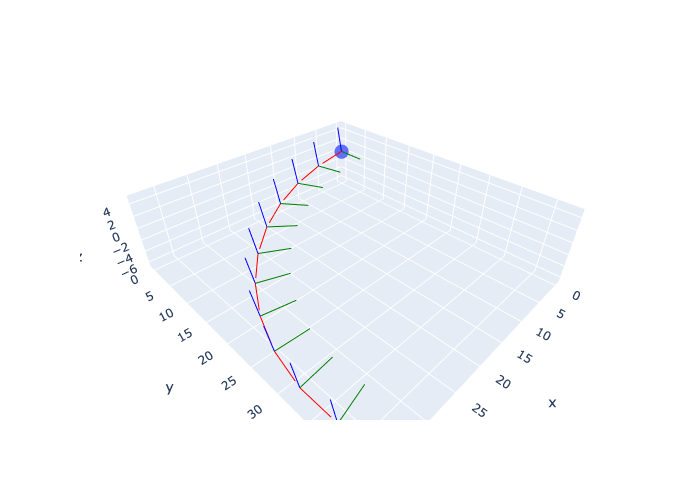

In [7]:
#| caption: Drone kinematics simulation.
#| label: fig:drone_kinematics
vn0 = nRb0.rotate(vb)  # velocity in navigation frame
drone = DroneKinematics(gtsam.Point3(0, 0, 0), vn0, nRb0, wb)

fig = px.scatter_3d(x=[0], y=[0], z=[0])
scale, labels = 5, ["F", "L", "U"]
fig.add_traces(axes(drone.pose(), scale, labels))
for k in range(10):
    drone.vn = drone.nRb.rotate(vb)  # velocity in navigation frame
    drone.integrate(dt=1)
    fig.add_traces(axes(drone.pose(), scale, labels))
fig.update_layout(showlegend=False, scene_aspectmode='data').show()

Above we used the `gtbook.drone.axes` method, which hides more magic to create the axes.You can see that the drone takes off in the positive $x$-direction, which is East in the ENU convention, and then gradually turns towards the north, which is indeed a counter-clockwise rotation around vertical!

### Exercises

- Change the direction of the turn to the other side.
- Change the code to use different values for $\Delta t$ and observe the results.
- Change the initial forward orientation to be the *northern* direction.

## Full Rigid-Body Dynamics

> Not hard to write down, but harder to understand.

```{index} torque, mass
```
Ultimately we need to move a quadrotor by providing forces through the four rotors.
Above we have discussed the forces that are applied by the rotors.
We now extend this idea to include **torque**, which is the rotational version of force.
The combination of forces and torques yields corresponding linear and angular accelerations.

Let us start with Newton's second law, with the acceleration $a$ written suggestively as $\dot{v}^n$, and immediately thinking in terms of force and velocity *vectors* in the navigation frame:
\begin{equation}
F^n = m \dot{v}^n
\end{equation}
The **mass** $m$ can be seen as a scalar that *resists* motion: the higher the mass, the higher the force needed to produce an acceleration in any direction. Note that we could consider $m$ to be a diagonal matrix with the mass on the diagonal: acceleration is resisted the same way in all three axes, in whatever coordinate frame we choose.

The same is (approximately) true for rotational motion.
If we write the torques on the quadrotor with respect to the body frame,
if the angular velocity is given by $\omega^b$,
the corresponding body torque is approximately given by
\begin{equation}
\tau^b \approx I \dot{\omega}^b
\end{equation}
This is only an approximation, because it ignores gyroscopic forces, but it is reasonable for small angular velocities $\omega^b$.

```{index} inertia matrix
```
Here the **inertia matrix** $I$ is resisting *angular* motion.
Expressed in an FLU body coordinate frame, the inertia matrix $I$ is typically approximated by a diagonal matrix with "small-small-big" diagonal elements, as the motor masses are further away from the $z$-axis than from the $x$- and 
$y$-axes, and hence resist acceleration around the $z$-axis more.

Let us calculate the moments of inertia assuming that each motor is 150 grams, and neglecting the body's mass for now. All four motors contribute to the moment of inertia $I_{xx}$ around the x-axis. Each motor, at a distance of $r = 0.1$ meters from the $x$-axis, contributes $m \times r^2$ to the moment of inertia, which gives:
\begin{equation}
I_{xx} = 4 \times 0.15 \times 0.1^2 = 0.006 \, \text{kg} \cdot \text{m}^2
\end{equation}
Because of symmetry, $I_{yy}$ has the same value. For the moment of inertia $I_{zz}$ about the z-axis what counts is the distance of each motor from the z-axis, which is $\sqrt{0.1^2 + 0.1^2}$ for each motor. Hence
\begin{equation}
I_{zz} = 4 \times 0.15 \times (0.1^2 + 0.1^2) = 0.012 \, \text{kg} \cdot \text{m}^2
\end{equation}
As you can see, because the motors are farther away from the $z$-axis than from the $x$- or $y$-axes, it takes twice the torque around the $z$-axis to get the same angular acceleration.

### Gyroscopic effects

> From the approximate to the exact.

If a quadrotor undergoes large angular velocities, we cannot ignore gyroscopic effects.
In this case, the (exact) rotational dynamics equation is given by:
\begin{equation}
\tau^b = I \dot{\omega}^b + \omega^b \times I \omega^b,
\end{equation}
where $\times$ is the vector cross-product. The second term is a set of quadratic components in the angular velocity $\omega^b$ and that is why for small angular velocities they can be ignored. In fact, in many cases the orientation of a quadrotor is *actively controlled* to stay constant during hovering or in fast forward flight, and it is only in complicated maneuvers that large angular velocities occur.

### Generating Force and Torque

What is still missing is how to translate from forces at the rotors to a force and torque on the *body*. In the body coordinate frame, the force equation is easy and we have seen it before:
\begin{equation}
F^b_z = f \doteq \sum_i f_i.
\end{equation}
Above the forces $f_i$ at the rotors are all oriented along the body $z$-coordinate axis (up!) and hence when we sum them we get a single force component $F^b_z$ along the body $z$-axis.

We also need to include the effect of gravity, which acts along the negative $z$-axis of the navigation frame. 
If we denote by $F_\mathrm{{tot}}$ the total force, which includes both the effects of the rotor thrusts and of gravity,
we have have: 
\begin{equation}
F_\mathrm{tot}^n = R^n_b F^b + m g^n
\end{equation}
where $F^b \doteq [0,0,f]^T$ is the 3D thrust vector in the body frame, and $g^n \doteq [0,0,-g]^T$ is the gravity vector, expressed in the navigation frame.

The torque $\tau^b$ in the body frame is a bit more involved, and is a function of the force vector $f$. The exact formula depends on the geometry of the rotors. For example, for a 4-motor “X” configuration with motor 1 forward left and numbered clockwise, we obtain
\begin{equation}
\tau^b = \begin{bmatrix}
l(f_{1}-f_{2}-f_{3}+f_{4})\\
l(f_{1}+f_{2}-f_{3}-f_{4})\\
\kappa (f_{1}-f_{2}+f_{3}-f_{4})\\
\end{bmatrix}
\end{equation}
where $l$ is the distance from the rotors to the center of mass, and $\kappa$ is a torque constant.
From this equation you can see that a quadrotor is like a differential-drive robot but with *two* differential axes. Controlling it is easy in principle: *tilt, then move*. A part of $F^b_z$ will be used to keep the quadrotor flying, the other part will be used to overcome drag and attain a constant velocity in the chosen direction.

The final piece of the puzzle is how exactly the rotors generate the individual forces $f_i$. We will not discuss that in detail here, but suffice to say that the forces $f_i$ are well understood functions of the rotor speed. Each motor also generates a small torque $\kappa f_i$ around it's rotor axis,  proportional to the force with proportionality constant $\kappa$. The rotation direction for each rotor determines which sign to use to calculate the $z$-component of the body torque $\tau^b$.

#### Exercises

- Try to deeply understand the torque vector above.
- Try to create the torque vector for a 4-motor "+" configuration.

### Putting it all together

> Kinematics and dynamics make motion.

Kinematics governs how states are moved by velocities, and dynamics governs how accelerations are changed by forces and moments. Putting things together, the full equations of motion for the drone then read:
\begin{equation}\begin{aligned}
\dot r^n &= v^n \\
\dot{R}^n_b	&=  R^n_b \hat{\omega}^b \\
m \dot v^n &= R^n_b F^b + m g^n \\
I \dot{\omega}^b &= \tau^b + \omega^b \times I \omega^b
\end{aligned}\end{equation}
where $r^n$, $v^n$, $R^n_b$, and $\omega^n$ are kinematic state, $F^b$ and $\tau^b$ are dynamic inputs, and $m$ and $I$ are system parameters.

With this, we can create the final version of a drone simulator, which we will use in Section 7.5. The final simulator code is given in Figure [4](#fig:drone_dynamics). The code calculates the linear velocity $v^n$ and angular velocity $\omega^b$ from the forces $F^b$ and torque $\tau^b$, and then integrates the kinematics using the inherited `integrate` method. Note we model drag but neglect gyroscopic effects. 

In [ ]:
#| caption: Drone simulation, full dynamics.
#| label: fig:drone_dynamics
@dataclass
class Drone(DroneKinematics):
    g: float = 9.81
    mass: float = 1.0
    k_d: float = 0.0425                        # drag coefficient
    gn: np.ndarray = gtsam.Point3(0, 0, -g)    # gravity vector in navigation frame.
    I_xy: float = 4 * 0.15 * mass * 0.1**2     # All 4 motors contribute to I_xy
    I_z: float = 4 * 0.15 * mass * 2 * 0.1**2  # I_z leverages longer arm
    I = np.diag([I_xy, I_xy, I_z])             # Inertia matrix

    # define integrate method that updates dynamics and then calls super's integrate method:
    def integrate(self, f: float, tau:gtsam.Point3, dt=1.0):
        """Integrate equations of motion given dynamic inputs f and tau."""
        # Calculate net force in navigation frame, including gravity and drag:
        Fb = gtsam.Point3(0, 0, f)
        drag_force = -self.k_d * self.vn * np.linalg.norm(self.vn)
        net_force = self.nRb.rotate(Fb) + self.gn + drag_force
        
        # Integrate velocity in navigation frame:
        self.vn += net_force * dt / self.mass

        # rotational drag, assume 10x smaller linearly proportional to angular velocity:
        net_tau = tau - 0.1 * self.k_d * self.wb

        # Integrate angular velocity in body frame:
        self.wb[0] += net_tau[0] * dt / self.I_xy
        self.wb[1] += net_tau[1] * dt / self.I_xy
        self.wb[2] += net_tau[2] * dt / self.I_z
        
        # Call super's integrate method for kinematics
        super().integrate(dt)

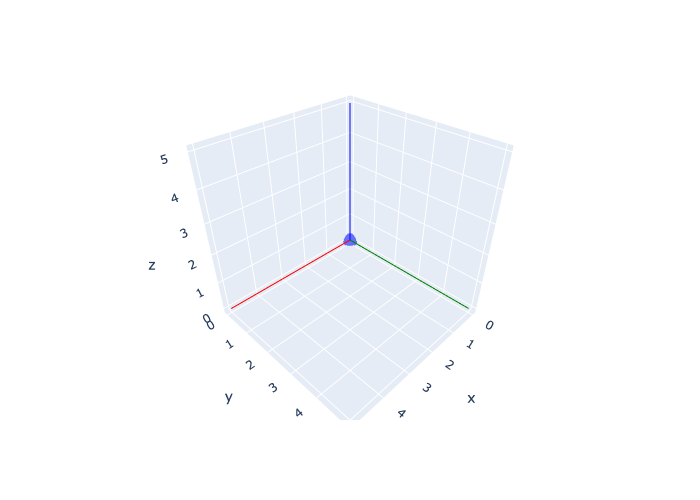

In [9]:
#| caption: Dynamics simulation of a drone hovering.
#| label: fig:drone_dynamics_hover
zero = lambda : gtsam.Point3(0, 0, 0)
drone = Drone(rn=zero(), vn=zero(), nRb=gtsam.Rot3(), wb=zero())
fig = px.scatter_3d(x=[0], y=[0], z=[0])
fig.add_traces(axes(drone.pose(), scale, labels))
for k in range(10):
    drone.integrate(9.81, zero(), dt=1)
    fig.add_traces(axes(drone.pose(), scale, labels))
fig.update_layout(showlegend=False, scene_aspectmode='data').show()

In Figure [5](#fig:drone_dynamics_hover) we verify that with just enough upward thrust ($f=9.81$) and zero torque, we attain a perfect hover. Because we model drag, for a given non-zero linear velocity the drone keeps moving because of inertia but slows down as time goes on, as we show in Figure [6](#fig:drone_dynamics_forward).

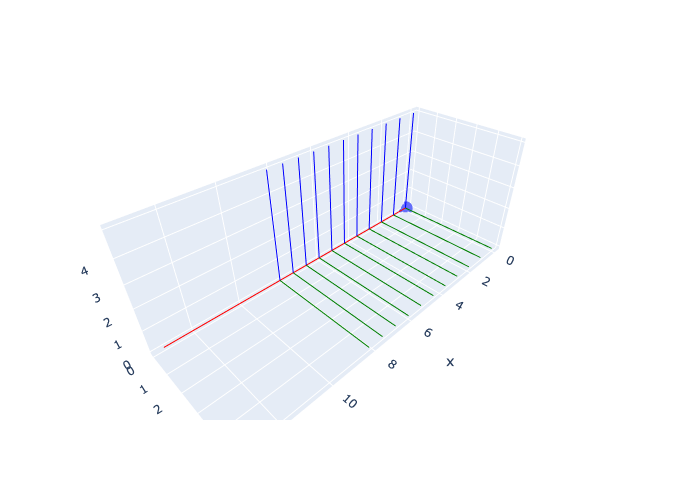

final velocity: [0.69 0.   0.  ]


In [10]:
#| caption: Dynamics simulation of a drone floating forward.
#| label: fig:drone_dynamics_forward
drone = Drone(rn=zero(), vn=gtsam.Point3(1, 0, 0), nRb=gtsam.Rot3(), wb=zero())
fig = px.scatter_3d(x=[0], y=[0], z=[0])
fig.add_traces(axes(drone.pose(), scale, labels))
for k in range(10):
    drone.integrate(9.81, zero(), dt=1)
    fig.add_traces(axes(drone.pose(), scale, labels))
fig.update_layout(showlegend=False, scene_aspectmode='data').show()
print("final velocity:", np.round(drone.vn, 2))

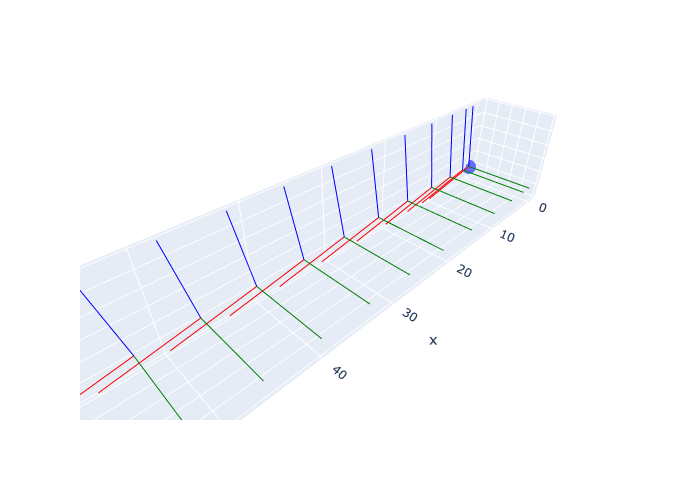

In [11]:
#| caption: Dynamics simulation of a drone accelerating through pitching.
#| label: fig:drone_dynamics_pitch
pitch = math.radians(10)
f = 9.81 / math.cos(pitch)
drone = Drone(rn=zero(), vn=zero(), nRb=gtsam.Rot3.Pitch(pitch), wb=zero())
fig = px.scatter_3d(x=[0], y=[0], z=[0])
scale, labels = 10, ["F", "L", "U"]
fig.add_traces(axes(drone.pose(), scale, labels))
for k in range(10):
    drone.integrate(f, zero(), dt=1)
    fig.add_traces(axes(drone.pose(), scale, labels))
fig.update_layout(showlegend=False, scene_aspectmode='data').show()

Finally, we can also execute fully dynamic maneuvers, as we illustrate in Figure [7](#fig:drone_dynamics_pitch). There we show the forward flight condition we discussed above. Note the drone speeds up from hover but fairly quickly reaches terminal velocity because of drag.
And in Figure [8](#fig:drone_dynamics_left) we show how applying a small torque can make the drone change direction. However, one's first instinct of rotating around the body Up/$z$-axis will not actually make the drone's trajectory curved! Indeed, in the body frame, rotating around the $z$-axis leaves the direction of the $z$-axis unchanged, and hence also the thrust exerted by the motors. While the "Forward" direction of the drone will change, only a change in the direction of thrust can make the center of mass move along a curve. A small moment "roll" around the Forward/$x$-axis does the trick, though.

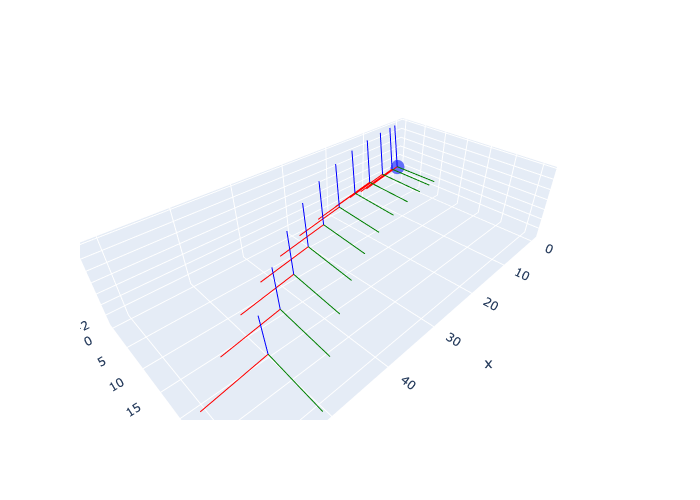

In [12]:
#| caption: Dynamics simulation of a drone curving left.
#| label: fig:drone_dynamics_left
drone = Drone(rn=zero(), vn=zero(), nRb=gtsam.Rot3.Pitch(pitch), wb=zero())
fig = px.scatter_3d(x=[0], y=[0], z=[0])
scale, labels = 10, ["F", "L", "U"]
fig.add_traces(axes(drone.pose(), scale, labels))
for k in range(10):
    drone.integrate(f, gtsam.Point3(-0.0001,0,0), dt=1)
    fig.add_traces(axes(drone.pose(), scale, labels))
fig.update_layout(showlegend=False, scene_aspectmode='data').show()

### Exercises:

- In this last scenario, is the drone curving the correct way? Think about the sign of the roll torque.
- What happens if you extend the simulation? Form a hypothesis first, then try it. Does the drone keep turning? Explain.